<a href="https://colab.research.google.com/github/arielle00/CMPE257-Fall23-Arielle-Shnayder/blob/homework2/hw2_task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [202]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

dfTrain = np.loadtxt("ZipDigits.train",delimiter=" ",usecols=range(0, 257))

dfTest = np.loadtxt("ZipDigits.test",delimiter=" ",usecols=range(0, 257))

print("df train :",dfTrain.shape)
print("df test :", dfTest.shape)

filtered_dfTrain = []
filtered_dfTest = []

filtered_dfTrain = dfTrain[(dfTrain[:, 0] == 1) | (dfTrain[:, 0] == 5)]
filtered_dfTest = dfTest[(dfTest[:, 0] == 1) | (dfTest[:, 0] == 5)]

filtered_dfTrain[:, 0] = np.where(filtered_dfTrain[:, 0] == 1, 1, -1)
filtered_dfTest[:, 0] = np.where(filtered_dfTest[:, 0] == 1, 1, -1)

def intensity(image):
    pixels = image[1:]
    #print(pixels.shape)
    return np.mean(pixels)

def hor_symmetry(image):
    # 16 x 16 = 256
    image_2d = image[1:].reshape(16, 16)
    upper_half = image_2d[:8,:]
    lower_half = image_2d[8:,:]
    lower_half_flipped = np.flipud(lower_half)
    return np.mean(np.abs(upper_half - lower_half_flipped))

intensities = np.array([intensity(img) for img in filtered_dfTrain])
symmetries = np.array([hor_symmetry(img) for img in filtered_dfTrain])
labels = filtered_dfTrain[:, 0]

df_train = pd.DataFrame({'x0': 1, 'x1':intensities, 'x2':symmetries, 'y':labels})


intensities_test = np.array([intensity(img) for img in filtered_dfTest])
symmetries_test = np.array([hor_symmetry(img) for img in filtered_dfTest])
labels_test = filtered_dfTest[:, 0]
df_test = pd.DataFrame({'x0': 1, 'x1':intensities_test, 'x2':symmetries_test, 'y':labels_test})

df train : (7291, 257)
df test : (2007, 257)


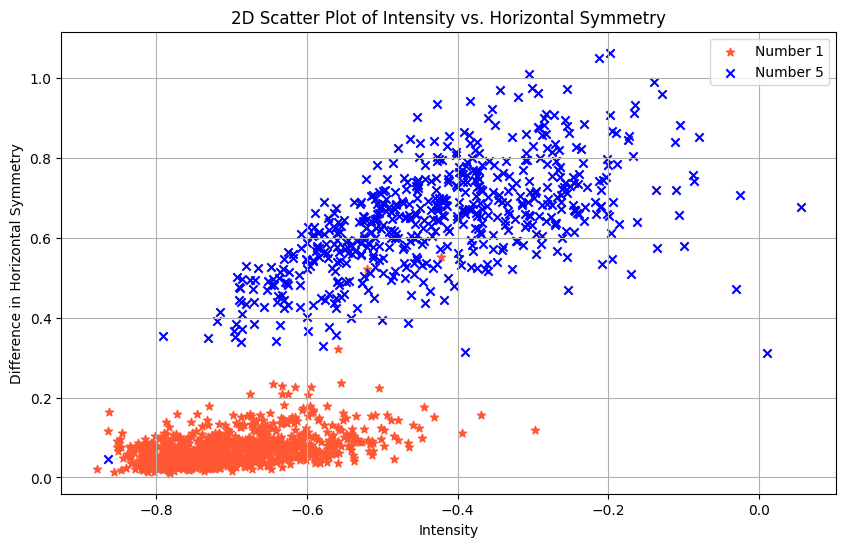

In [203]:
# Training data
plt.figure(figsize=(10, 6))
plt.scatter(intensities[labels==1], symmetries[labels==1], color = '#FF5733', marker='*', label='Number 1')
plt.scatter(intensities[labels==-1], symmetries[labels==-1], color = 'blue', marker='x', label='Number 5')

plt.xlabel("Intensity")
plt.ylabel("Difference in Horizontal Symmetry")
plt.title("2D Scatter Plot of Intensity vs. Horizontal Symmetry")
plt.legend()
plt.grid(True)
plt.show()

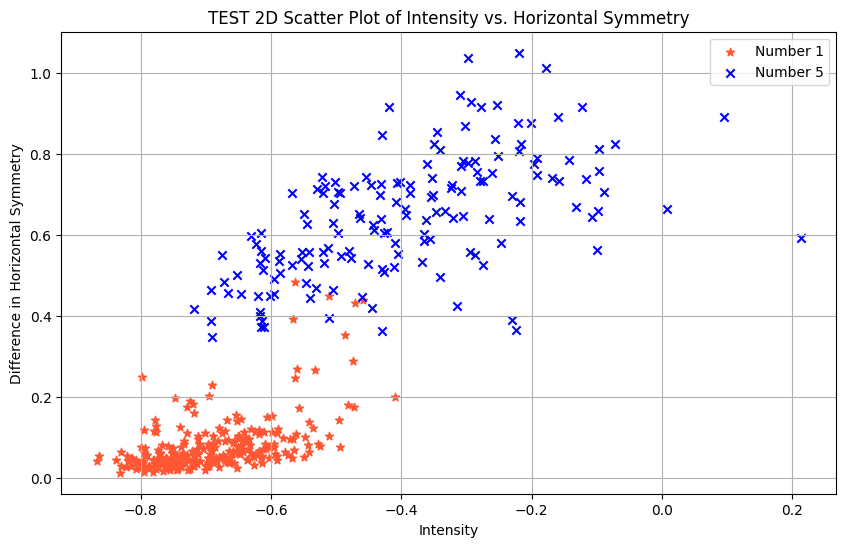

In [204]:
# Test data
plt.figure(figsize=(10, 6))
plt.scatter(intensities_test[labels_test==1], symmetries_test[labels_test==1], color = '#FF5733', marker='*', label='Number 1')
plt.scatter(intensities_test[labels_test==-1], symmetries_test[labels_test==-1], color = 'blue', marker='x', label='Number 5')

plt.xlabel("Intensity")
plt.ylabel("Difference in Horizontal Symmetry")
plt.title("TEST 2D Scatter Plot of Intensity vs. Horizontal Symmetry")
plt.legend()
plt.grid(True)
plt.show()

In [205]:
def check_for_misclassified(w, df):
  misclassified = []
  w = np.array(w)
  signs = np.sign(np.dot(df.iloc[:, :-1].values, w))
  y = df.iloc[:, -1].values

  mismatches = np.where(signs != y)[0]

  return mismatches

PLA
Ein: 0.04225560538116592
This is the final weight:  [ 4.          0.04644922 -9.05677344]


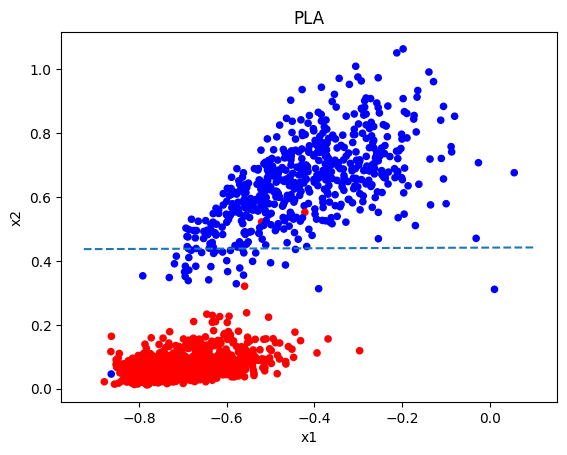

In [206]:
def plot_graph(w, msg):
  col = df_train['y'].map({-1:'b', 1:'r'})
  df_train.plot.scatter(x='x1', y='x2', c=col)
  axes = plt.gca()
  x_vals = np.array(axes.get_xlim())
  y_vals = np.array(axes.get_ylim())
  y_vals = -w[0]/w[2] - w[1]/w[2] * x_vals
  plt.title(msg)
  plt.plot(x_vals, y_vals, '--')


Ein_pla=[]
def perceptron():
  w = [0,0,0]
  misclassified_points = check_for_misclassified(w, df_train)
  i=0

  while(len(misclassified_points)!=0 and i<1000):

    Ein_pla.append(len(misclassified_points)/len(df_train))

    j = random.randint(0, len(misclassified_points)-1)
    x = df_train.iloc[misclassified_points[j]].values[:-1]
    y = df_train.iloc[misclassified_points[j]].values[-1]

    w = w + x*y

    misclassified_points = check_for_misclassified(w, df_train)

    i=i+1

  print("PLA")
  print("Ein:",np.mean(Ein_pla))
  print("This is the final weight: ",w)
  plot_graph(w, "PLA")
  return w

w_pla = perceptron()

      x0        x1        x2    y
0      1 -0.111738  0.840477 -1.0
1      1 -0.753914  0.059531  1.0
2      1 -0.772281  0.070547  1.0
3      1 -0.769258  0.037000  1.0
4      1 -0.795438  0.043797  1.0
...   ..       ...       ...  ...
1556   1 -0.289414  0.585484 -1.0
1557   1 -0.534238  0.592164 -1.0
1558   1 -0.609793  0.088102  1.0
1559   1 -0.662309  0.052742  1.0
1560   1 -0.447559  0.098211  1.0

[1561 rows x 4 columns]
[ 1.         -1.22499609 -5.69642969]


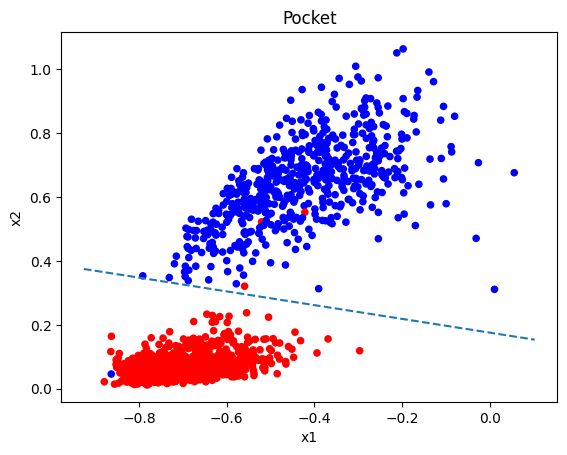

In [207]:
def pocketAlgo(misclassified_function, df_train, plot):
  i = 0

  num_features = df_train.shape[1] - 1  # excluding the label column
  # print(num_features)
  w_pocket = np.zeros(num_features)
  w_maybe_new = w_pocket
  misclassified_points_with_pocket =  misclassified_function(w_pocket, df_train)

  while (len(misclassified_points_with_pocket)!= 0 and i<1000):
    misclassified_points = misclassified_function(w_maybe_new, df_train)
    j = random.randint(0, len(misclassified_points)-1)

    x = df_train.iloc[misclassified_points[j]].values[:-1]
    y = df_train.iloc[misclassified_points[j]].values[-1]

    w_maybe_new = w_maybe_new + x*y
    new_misclassified_points = misclassified_function(w_maybe_new, df_train)

    if len(new_misclassified_points) < len(misclassified_points_with_pocket):
      w_pocket = w_maybe_new.copy()
      misclassified_points_with_pocket = misclassified_function(w_pocket, df_train)
    i = i + 1

  #print(w_pocket)
  plot(w_pocket,"Pocket")

  return w_pocket


# w_pocket = [0,0,0]
print(df_train)
w_pocket = pocketAlgo(check_for_misclassified, df_train, plot_graph)
print(w_pocket)

In [208]:
X_test = df_test.iloc[:, :-1].values  # Extract input features
y_test = df_test.iloc[:, -1].values   # Extract true labels

y_pred = np.sign(np.dot(X_test,w_pocket))
y_pred_pla = np.sign(np.dot(X_test,w_pla))

error_rate_test = np.mean(y_pred != y_test)
error_rate_test_pla = np.mean(y_pred_pla != y_test)

print(f"Error rate on test set and PLA: {error_rate_test_pla:.2f}")
print(f"Error rate on test set and Pocket: {error_rate_test:.2f}")


Error rate on test set and PLA: 0.04
Error rate on test set and Pocket: 0.02


In [209]:
df_train_3rd = pd.DataFrame({'x0': 1, 'x1':intensities, 'x2':symmetries, 'y':labels})
df_train_3rd['x1*x2'] = df_train['x1']*df_train['x2']
df_train_3rd['x1^2'] = df_train['x1']**2
df_train_3rd['x2^2'] = df_train['x2']**2
df_train_3rd['x1^3'] = df_train['x1']**3
df_train_3rd['x2^3'] = df_train['x2']**3
df_train_3rd['x1^2*x2'] = df_train['x1']**2 * df_train['x2']
df_train_3rd['x1*x2^2'] = df_train['x1'] * df_train['x2']**2

cols = [col for col in df_train_3rd if col != 'y'] + ['y']
df_train_3rd = df_train_3rd[cols]
# print(df_train_3rd)


In [210]:
color_1 = np.where(df_train["y"]==1, "red", "blue")
def plot3poly(w, msg):
    w0, w1, w2, w3, w4, w5, w6, w7, w8, w9 = w
    print(w)
    plt.scatter(list(df['x1']), list(df['x2']), c=color_1)
    axes = plt.gca()
    xlims = axes.get_xlim()
    ylims = axes.get_ylim()
    x1 = np.linspace(xlims[0], xlims[1], 1000)
    x2 = np.linspace(ylims[0], ylims[1], 1000)

    # meshgrid
    XM1, XM2 = np.meshgrid(x1, x2)
    Z = w0 + w1*XM1 + w2*XM2 + w3*XM1*XM2 + w4*XM1**2 + w5*XM2**2 + w6*XM1**3 + w7*XM2**3 + w8*XM1**2*XM2 + w9*XM1*XM2**2
    plt.contour(XM1, XM2, Z, 1, colors='blue')


[ 1.         -1.02347266 -3.38858594  1.57780506  0.54662484 -2.51572318
 -0.14952197 -1.65460227 -0.89058085  1.13387972]


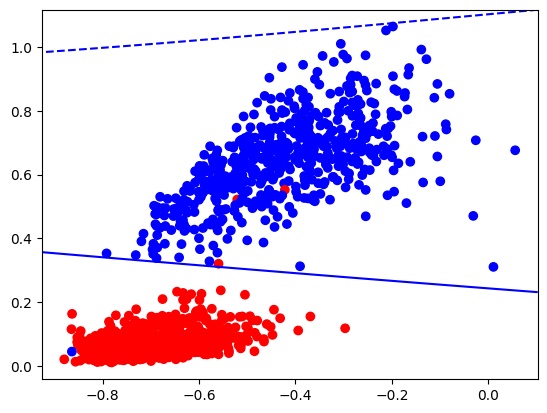

In [211]:
w_3rd = pocketAlgo(check_for_misclassified, df_train_3rd, plot3poly)

In [212]:
df_test_3d = pd.DataFrame({'x0': 1, 'x1':intensities_test, 'x2':symmetries_test, 'y':labels_test})
df_test_3d['x1*x2'] = df_test['x1']*df_test['x2']
df_test_3d['x1^2'] = df_test['x1']**2
df_test_3d['x2^2'] = df_test['x2']**2
df_test_3d['x1^3'] = df_test['x1']**3
df_test_3d['x2^3'] = df_test['x2']**3
df_test_3d['x1^2*x2'] = df_test['x1']**2 * df_test['x2']
df_test_3d['x1*x2^2'] = df_test['x1'] * df_test['x2']**2

cols = [col for col in df_test_3d if col != 'y'] + ['y']
df_test_3d = df_test_3d[cols]

X_test = df_test_3d.iloc[:, :-1].values  # Extract input features
y_test = df_test_3d.iloc[:, -1].values   # Extract true labels

y_pred = np.sign(np.dot(X_test,w_3rd))

error_rate_test = np.mean(y_pred != y_test)

print(f"Error rate on test set and Pocket: {error_rate_test:.2f}")

Error rate on test set and Pocket: 0.01
